**Exercise 1.** Use torchvision to implement random cropping of the data.

a. How are the resulting images different from the uncropped originals?

b. What happens when you request the same image a second time?

c. What is the result of training using randomly cropped images?

In [ ]:
!pip install -q datasets

In [ ]:
!pip install -q wandb

If running this notebook in Colab, please ensure that your Hugging Face `HF_TOKEN` and your Weights & Biases `WANDB_API_KEY` are added to your Colab secrets.

Alternatively, please login to Hugging Face and Weights & Biases by running the following two cells.

In [ ]:
# !huggingface-cli login

In [ ]:
# !wandb login

In [ ]:
import os
import random
import numpy as np
import torch

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [ ]:
from datasets import load_dataset

cifar10 = load_dataset("cifar10")
cifar10

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
features = cifar10['train'].features
features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [ ]:
id2label = {id: label for id, label in enumerate(features['label'].names)}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

Foe the sake of comparison and learning, we shall try out three different transforms.

In [ ]:
from torchvision.transforms import v2

random_crop24 = v2.RandomCrop(24)
random_crop32 = v2.RandomCrop(32)
random_resized_crop32 = v2.RandomResizedCrop(32, scale=(0.5, 0.75))

**Documentations:**

- <a href="https://pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomCrop.html" target="_blank">RandomCrop</a>: Crop the input at a random location.


- <a href="https://pytorch.org/vision/main/generated/torchvision.transforms.v2.RandomResizedCrop.html" target="_blank">RandomResizedCrop</a>: Crop a random portion of the input and resize it to a given size. (So, it's a two step procedure.)

    > **scale** *(tuple of python:float, optional)* - Specifies the lower and upper bounds for the random area of the crop, before resizing. The scale is defined with respect to the area of the original image.

In [ ]:
example0 = cifar10['train'][0]
example0

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

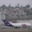

In [ ]:
example0['img']

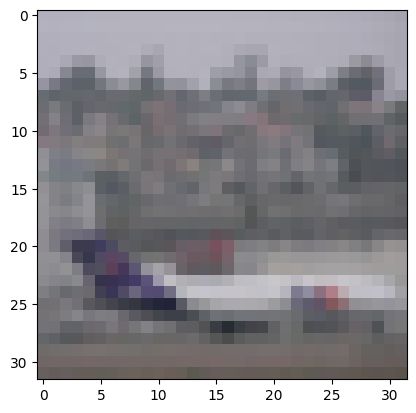

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example0['img']);

In [ ]:
id2label[example0['label']]

'airplane'

In [ ]:
random_crop24(example0['img'])

In [ ]:
type(random_crop24(example0['img']))

PIL.Image.Image

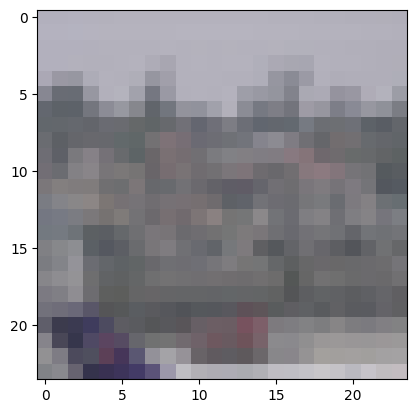

In [ ]:
plt.imshow(random_crop24(example0['img']));

Answer to (a): A 24px by 24px image patch is cropped at random.

Performing the same transform a second time:

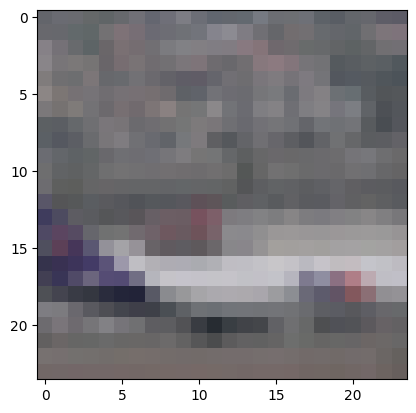

In [ ]:
plt.imshow(random_crop24(example0['img']));

Answer to (b): A different random patch is chosen the second time.

Comparison with `RandomCrop(32)`:

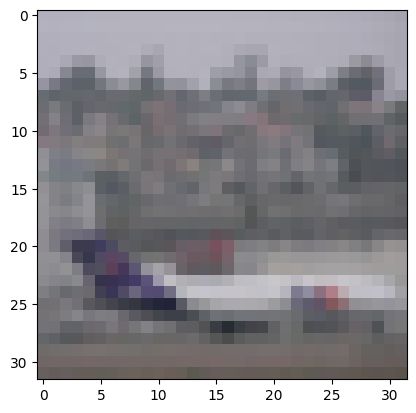

In [ ]:
plt.imshow(random_crop32(example0['img']));

The image is unchanged from the original.

Comparison with `RandomResizedCrop(32, scale=(0.5, 0.75))`:

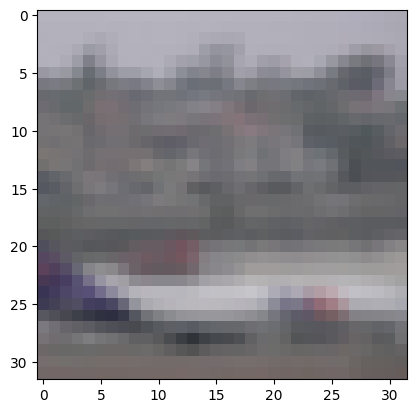

In [ ]:
plt.imshow(random_resized_crop32(example0['img']));

A random patch is cropped. Then, the patch is resized to a 32px by 32px image.

Let's do a couple of more images to get a feel for these transforms.

In [ ]:
example1 = cifar10['train'][1]
example1

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 6}

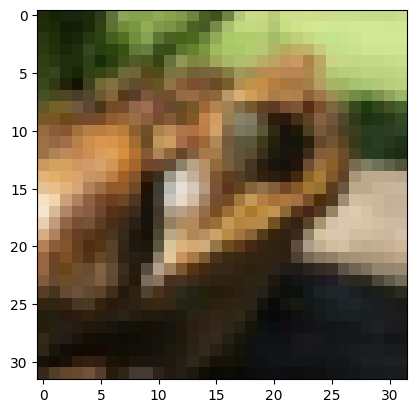

In [ ]:
plt.imshow(example1['img']);

In [ ]:
id2label[example1['label']]

'frog'

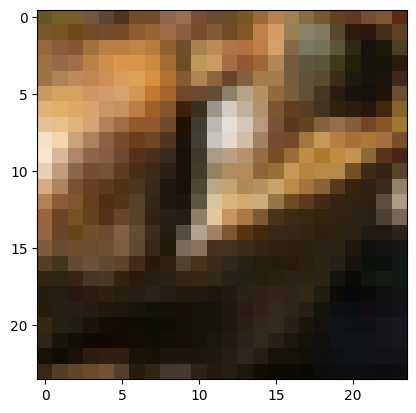

In [ ]:
plt.imshow(random_crop24(example1['img']));

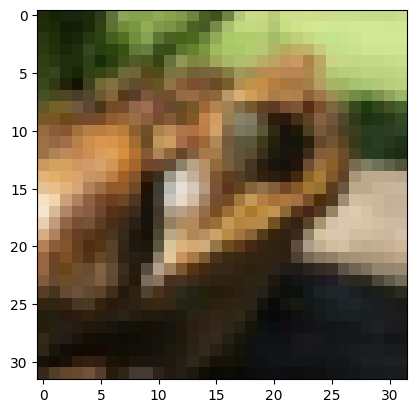

In [ ]:
plt.imshow(random_crop32(example1['img']));

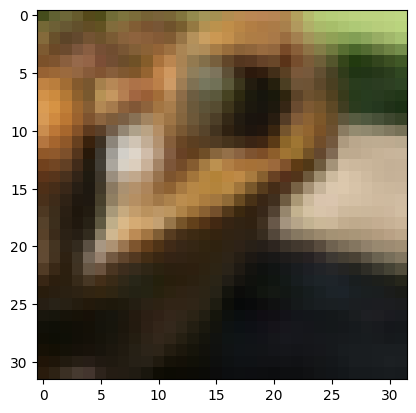

In [ ]:
plt.imshow(random_resized_crop32(example1['img']));

In [ ]:
example2 = cifar10['train'][2]
example2

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0}

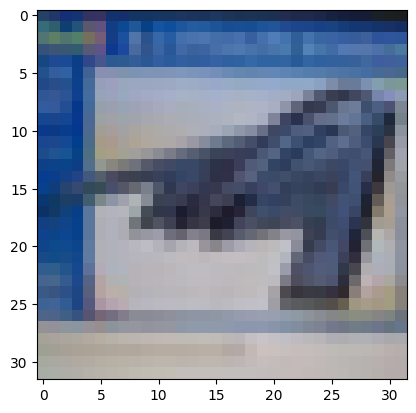

In [ ]:
plt.imshow(example2['img']);

In [ ]:
id2label[example2['label']]

'airplane'

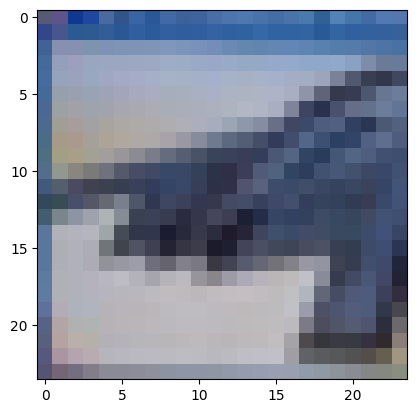

In [ ]:
plt.imshow(random_crop24(example2['img']));

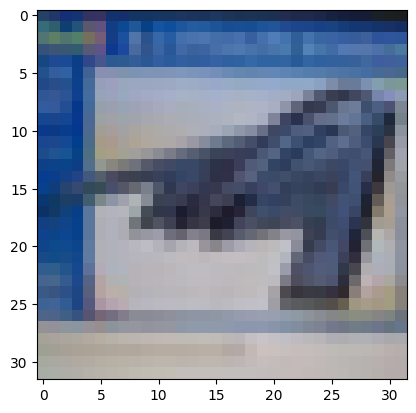

In [ ]:
plt.imshow(random_crop32(example2['img']));

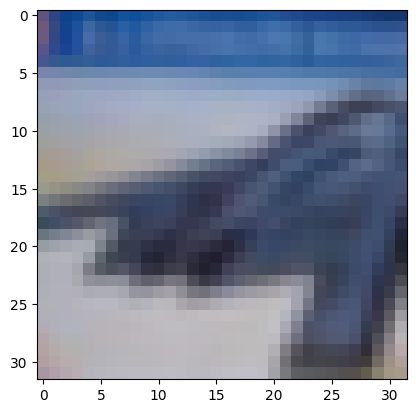

In [ ]:
plt.imshow(random_resized_crop32(example2['img']));

Now, let's create a PyTorch `Dataset` for model training.

In [ ]:
from torch.utils.data import Dataset

class CIFAR10Dataset(Dataset):
    def __init__(self, dataset, tfms):
        self.dataset = dataset
        self.tfms = tfms

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        img, label = item['img'], item['label']
        img = self.tfms(img)
        return img, label

**Note:** There is no need to convert `label` to a tensor as the data collator will collate the integers into a tensor anyway.

In [ ]:
train_tfms = v2.Compose([
    v2.RandomCrop(24),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616])
])
cifar10_train = CIFAR10Dataset(cifar10['train'], train_tfms)
len(cifar10_train)

50000

**Note:** `ToImage()` along with `ToDtype(torch.float32, scale=True)` is a replacement for `ToTensor()` in `torchvision.transforms.v2`.

In [ ]:
# Sanity check:
img, label = cifar10_train[0]
img.shape, label

(torch.Size([3, 24, 24]), 0)

In [ ]:
val_tfms = v2.Compose([
    v2.Resize(24),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.4915, 0.4823, 0.4468], std=[0.2470, 0.2435, 0.2616])
])
cifar10_val = CIFAR10Dataset(cifar10['test'], val_tfms)
len(cifar10_val)

10000

**Note:** In the validation set, we replaced `RandomCrop(24)` with `Resize(24)`.

In [ ]:
# Sanity check:
img, label = cifar10_val[0]
img.shape, label

(torch.Size([3, 24, 24]), 3)

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

In [ ]:
cifar2_train = [(img, label_map[label]) for img, label in cifar10_train if label in [0, 2]]
len(cifar2_train)

10000

In [ ]:
# Sanity check:
img, label = cifar2_train[0]
img.shape, label

(torch.Size([3, 24, 24]), 0)

In [ ]:
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]
len(cifar2_val)

2000

In [ ]:
# Sanity check:
img, label = cifar2_val[0]
img.shape, label

(torch.Size([3, 24, 24]), 0)

In [ ]:
batch_size = 64

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(cifar2_train, batch_size=batch_size, shuffle=True, num_workers=2)
len(train_dl)

157

In [ ]:
# Sanity check:
imgs, labels = next(iter(train_dl))
imgs.shape, labels.shape

(torch.Size([64, 3, 24, 24]), torch.Size([64]))

In [ ]:
val_dl = DataLoader(cifar2_val, batch_size=batch_size, shuffle=False, num_workers=2)
len(val_dl)

32

In [ ]:
# Sanity check:
imgs, labels = next(iter(val_dl))
imgs.shape, labels.shape

(torch.Size([64, 3, 24, 24]), torch.Size([64]))

Now, let's define our multi-layer perceptron.

In [ ]:
# Number of inputs:
3 * 24 * 24

1728

In [ ]:
import torch.nn as nn
from huggingface_hub import PyTorchModelHubMixin

class MLPForCIFAR2(nn.Module, PyTorchModelHubMixin):
    """Multi-layer perceptron (MLP) for classifying 'airplane' vs. 'bird' in the CIFAR-2 dataset (a subset of CIFAR-10)."""

    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(1728, 1024), # Hidden layer.
            nn.Tanh(),
            nn.Linear(1024, 512), # Hidden layer.
            nn.Tanh(),
            nn.Linear(512, 128), # Hidden layer.
            nn.Tanh(),
            nn.Linear(128, 2) # Output layer.
        )

    def forward(self, x):
        return self.mlp(x)

model = MLPForCIFAR2()
model

MLPForCIFAR2(
  (mlp): Sequential(
    (0): Linear(in_features=1728, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
# Sanity check:
with torch.no_grad():
    batch_dim = imgs.shape[0]
    logits = model(imgs.view(batch_dim, -1)) # Flatten.
logits.shape

torch.Size([64, 2])

In [ ]:
from torch.optim import SGD

loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-2
optimizer = SGD(model.parameters(), lr=learning_rate)
n_epochs = 100

In [ ]:
import wandb

wandb.init(
    project="mlp-cifar2",
    config={
        'architecture': "MLP with 3 hidden layers",
        'dataset': "CIFAR-2",
        'learning_rate': learning_rate,
        'n_epochs': n_epochs,
        'batch_size': batch_size
    }
)

wandb: Currently logged in as: sadhaklal. Use `wandb login --relogin` to force relogin


In [ ]:
best_epoch = 0
best_acc = 0
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    for imgs, labels in train_dl:
        batch_dim = imgs.shape[0]
        outputs = model(imgs.view(batch_dim, -1))
        loss = loss_fn(outputs, labels)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(cifar2_train)
    train_loss = round(train_loss, 4)
    print(f"Epoch: {epoch}, Training Loss: {train_loss}")

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            batch_dim = imgs.shape[0]
            outputs = model(imgs.view(batch_dim, -1))
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
        val_loss /= len(cifar2_val)
        val_loss = round(val_loss, 4)
        acc = round(correct / len(cifar2_val), 4)
        print(f"Validation Loss: {val_loss}, Accuracy: {acc}")

    wandb.log({
        'train_loss': train_loss,
        'val_loss': val_loss,
        'accuracy': acc
    })

    if acc > best_acc:
        best_epoch = epoch
        best_acc = acc
        model.push_to_hub("mlp-cifar2", commit_message=f"epoch: {epoch}, accuracy: {acc}")

    print("---")
wandb.finish()
print("---")
print(f"Best Epoch: {best_epoch}, Best Accuracy: {best_acc}")

Epoch: 0, Training Loss: 0.0087
Validation Loss: 0.0081, Accuracy: 0.764


pytorch_model.bin:   0%|          | 0.00/9.45M [00:00<?, ?B/s]

---
Epoch: 1, Training Loss: 0.0081
Validation Loss: 0.0078, Accuracy: 0.7725


pytorch_model.bin:   0%|          | 0.00/9.45M [00:00<?, ?B/s]

---
Epoch: 2, Training Loss: 0.0079
Validation Loss: 0.0077, Accuracy: 0.7895


pytorch_model.bin:   0%|          | 0.00/9.45M [00:00<?, ?B/s]

---
Epoch: 3, Training Loss: 0.0078
Validation Loss: 0.0076, Accuracy: 0.7835
---
Epoch: 4, Training Loss: 0.0077
Validation Loss: 0.0075, Accuracy: 0.7845
---
Epoch: 5, Training Loss: 0.0077
Validation Loss: 0.0076, Accuracy: 0.7995


pytorch_model.bin:   0%|          | 0.00/9.45M [00:00<?, ?B/s]

---
Epoch: 6, Training Loss: 0.0076
Validation Loss: 0.0074, Accuracy: 0.7905
---
Epoch: 7, Training Loss: 0.0075
Validation Loss: 0.0073, Accuracy: 0.802


pytorch_model.bin:   0%|          | 0.00/9.45M [00:00<?, ?B/s]

---
Epoch: 8, Training Loss: 0.0074
Validation Loss: 0.0072, Accuracy: 0.8
---
Epoch: 9, Training Loss: 0.0073
Validation Loss: 0.0073, Accuracy: 0.7915
---
Epoch: 10, Training Loss: 0.0073
Validation Loss: 0.0076, Accuracy: 0.798
---
Epoch: 11, Training Loss: 0.0071
Validation Loss: 0.0073, Accuracy: 0.7865
---
Epoch: 12, Training Loss: 0.0071
Validation Loss: 0.0072, Accuracy: 0.8
---
Epoch: 13, Training Loss: 0.007
Validation Loss: 0.0074, Accuracy: 0.792
---
Epoch: 14, Training Loss: 0.0069
Validation Loss: 0.0073, Accuracy: 0.793
---
Epoch: 15, Training Loss: 0.0068
Validation Loss: 0.0077, Accuracy: 0.7835
---
Epoch: 16, Training Loss: 0.0067
Validation Loss: 0.007, Accuracy: 0.809


pytorch_model.bin:   0%|          | 0.00/9.45M [00:00<?, ?B/s]

---
Epoch: 17, Training Loss: 0.0067
Validation Loss: 0.0078, Accuracy: 0.78
---
Epoch: 18, Training Loss: 0.0066
Validation Loss: 0.0071, Accuracy: 0.8015
---
Epoch: 19, Training Loss: 0.0065
Validation Loss: 0.0071, Accuracy: 0.8015
---
Epoch: 20, Training Loss: 0.0064
Validation Loss: 0.0074, Accuracy: 0.7955
---
Epoch: 21, Training Loss: 0.0063
Validation Loss: 0.0115, Accuracy: 0.613
---
Epoch: 22, Training Loss: 0.0062
Validation Loss: 0.0073, Accuracy: 0.7925
---
Epoch: 23, Training Loss: 0.0062
Validation Loss: 0.008, Accuracy: 0.771
---
Epoch: 24, Training Loss: 0.0059
Validation Loss: 0.0088, Accuracy: 0.774
---
Epoch: 25, Training Loss: 0.0059
Validation Loss: 0.0116, Accuracy: 0.7555
---
Epoch: 26, Training Loss: 0.0059
Validation Loss: 0.0137, Accuracy: 0.603
---
Epoch: 27, Training Loss: 0.0056
Validation Loss: 0.0091, Accuracy: 0.763
---
Epoch: 28, Training Loss: 0.0056
Validation Loss: 0.0081, Accuracy: 0.774
---
Epoch: 29, Training Loss: 0.0055
Validation Loss: 0.0088,

accuracy,▇█████▇▇██▇▇▇▁██▆▂██▇▇█▇█▇█▇██▇██▇██████
train_loss,█▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▂▂▁█▂▁▂▅▂▂▂▂▂▃▂▃▃▃▃▄▇▃▃▅▃▄▄▄▄▄
accuracy,0.792
train_loss,0.0005
val_loss,0.0177


---
Best Epoch: 16, Best Accuracy: 0.809


Let's reload the weights of the best epoch, and then calculate the metrics on the training set and validation set.

In [ ]:
model = MLPForCIFAR2.from_pretrained("sadhaklal/mlp-cifar2")
model.eval()

MLPForCIFAR2(
  (mlp): Sequential(
    (0): Linear(in_features=1728, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [ ]:
# Training set accuracy:
correct = 0
with torch.no_grad():
    for imgs, labels in train_dl:
        batch_dim = imgs.shape[0]
        outputs = model(imgs.view(batch_dim, -1))
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
print(f"Accuracy: {correct / len(cifar2_train):.4f}")

Accuracy: 0.8217


In [ ]:
# Validation set accuracy:
correct = 0
with torch.no_grad():
    for imgs, labels in val_dl:
        batch_dim = imgs.shape[0]
        outputs = model(imgs.view(batch_dim, -1))
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
print(f"Accuracy: {correct / len(cifar2_val):.4f}")

Accuracy: 0.8090


The accuracy achieved without the `RandomCrop(24)` augmentation was 0.801. (**Reference notebook:** https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch7/2_birds_airplanes.ipynb)

Answer to (c): Adding the `RandomCrop(24)` augmentation doesn't have much of an impact on accuracy.